<a href="https://colab.research.google.com/github/u2200579/Sentiment-Analysis/blob/main/Sentiment_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 287 kB 35.2 MB/s 


**Import Dependecies**

In [2]:
import re
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import contractions
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import datasets and glove embeddings for deep learning model

In [4]:
!cp "/content/drive/My Drive/Train.csv" "train"
!cp "/content/drive/My Drive/Valid.csv" "valid"
!cp "/content/drive/My Drive/Test.csv" "test"
# !cp "/content/drive/My Drive/glove.6B.50d.txt" "glove"

In [5]:
#Imported twitter dataset into a dataframe to structure data and named the columns
df = pd.read_csv('train')
df1 = pd.read_csv('valid')
df2 = pd.read_csv('test')

**Analysing Dataset and Class distribution**






In [ ]:
df["label"].value_counts(normalize = True) #Find the ratio of each class to observe if there is a class imbalance

0    0.500475
1    0.499525
Name: label, dtype: float64

**Visualising training dataset and observe top 20 words**





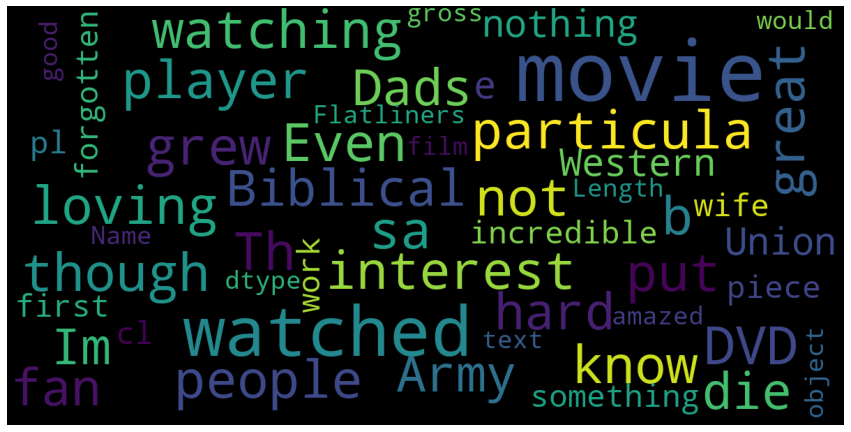

In [6]:
from wordcloud import WordCloud
stop = stopwords.words('english')
stop.remove("not")
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['text'])

In [ ]:
pd.Series(' '.join(df['text']).lower().split()).value_counts()[:20]

not          95828
movie        78699
film         71601
one          42269
make         34771
like         34101
see          32583
get          28139
good         26006
would        24860
time         23630
character    21679
watch        20812
well         20248
even         19951
bad          19368
story        19245
really       18426
think        17643
show         16850
dtype: int64

***Preprocessing Datasets***


Each tweet is pre-processed to remove objects such as hashtags and URL's. Cintractions are substituted with components and Lemmatization has been utilised along with stopword removal without including "not"
.

In [7]:
def remove_contraction(text):
  return contractions.fix(text)

def remove_noise(tweet):
# remove links, hashtags, numbers, @..., and punctuation uing function
    tweet = re.sub(r'https?:\/\/.*[\r\n]*','',tweet)
    tweet = re.sub(r'#','',tweet)
    tweet = re.sub(r'(@[A-Za-z0-9]+)','',tweet)
    return tweet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 2]
    # join all
    text = " ".join(text)
    return(text)

Applying functions to all datasets

In [8]:
#applying tokenisation to dataframe containing training data
df['text'] = df['text'].apply(remove_noise)
df['text'] = df['text'].apply(remove_contraction)
df['text'] = df['text'].apply(clean_text)
x_train = df['text']
df1['text'] = df1['text'].apply(remove_noise)
df1['text'] = df1['text'].apply(remove_contraction)
df1['text'] = df1['text'].apply(clean_text)
x_valid = df1['text']
df2['text'] = df2['text'].apply(remove_noise)
df2['text'] = df2['text'].apply(remove_contraction)
df2['text'] = df2['text'].apply(clean_text)
x_test = df2['text']
y_train = df['label']
y_valid = df1['label']
y_test = df2['label']

Calculate word statistics to help with features for Word embeddings

In [51]:
df['token'] = df['text'].str.split()
df['token'].str.len().describe()

count    40000.000000
mean       117.720725
std         88.550639
min          0.000000
25%         63.000000
50%         87.000000
75%        144.000000
max       1387.000000
Name: token, dtype: float64

Vectorisation for model input

In [16]:
tf = TfidfVectorizer(stop_words=None, max_features=2000, min_df=2)
x_train_vec = tf.fit_transform(x_train)
x_valid_vec = tf.transform(x_valid)
x_test_vec = tf.transform(x_test)

## 1.**Support Vector Machines Model**

In [17]:
#train model on training data set and validate on validation set
svm = LinearSVC()
svm.fit(x_train_vec, y_train)
y_pred1=svm.predict(x_valid_vec)
cf = classification_report(y_valid,y_pred1)
print(cf)

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2486
           1       0.86      0.88      0.87      2514

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [18]:
#test models on test data set
y_pred11=svm.predict(x_test_vec)
cf = classification_report(y_test,y_pred11)
print(cf)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2495
           1       0.86      0.88      0.87      2505

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



## 2. **Naive Bayes Model**

In [19]:
NB = MultinomialNB()
NB.fit(x_train_vec,y_train)
y_pred2=NB.predict(x_valid_vec)
cf = classification_report(y_valid,y_pred2)
print(cf)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      2486
           1       0.83      0.85      0.84      2514

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [20]:
y_pred22=NB.predict(x_test_vec)
cf = classification_report(y_test,y_pred22)
print(cf)

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2495
           1       0.84      0.87      0.85      2505

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



## 3. **Maximum Entropy Model**

In [21]:
maxent = LogisticRegression()
maxent.fit(x_train_vec, y_train)
y_pred3= maxent.predict(x_valid_vec)
cf = classification_report(y_valid,y_pred3)
print(cf)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2486
           1       0.86      0.88      0.87      2514

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [22]:
y_pred33= maxent.predict(x_test_vec)
cf = classification_report(y_test,y_pred33)
print(cf)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2495
           1       0.87      0.88      0.88      2505

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



## 4. **LSTM Model**


LSTM networks are useful in sequence data as they are capable of remembering the past words which help them in understanding the meaning of the sentence which helps in text classification. 


In [15]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Embedding, LSTM 

Function to read the contents of the GloVe Vector file, and returns dictionary that maps the words to their respective word embeddings.

In [10]:
words = dict()
def add_to_dict(d,filename):
  with open('glove', encoding='utf8') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]]=np.array(line[1:], dtype = float)
      except:
        continue

add_to_dict(words,'glove')

In [53]:
words['good']

array([-3.5586e-01,  5.2130e-01, -6.1070e-01, -3.0131e-01,  9.4862e-01,
       -3.1539e-01, -5.9831e-01,  1.2188e-01, -3.1943e-02,  5.5695e-01,
       -1.0621e-01,  6.3399e-01, -4.7340e-01, -7.5895e-02,  3.8247e-01,
        8.1569e-02,  8.2214e-01,  2.2220e-01, -8.3764e-03, -7.6620e-01,
       -5.6253e-01,  6.1759e-01,  2.0292e-01, -4.8598e-02,  8.7815e-01,
       -1.6549e+00, -7.7418e-01,  1.5435e-01,  9.4823e-01, -3.9520e-01,
        3.7302e+00,  8.2855e-01, -1.4104e-01,  1.6395e-02,  2.1115e-01,
       -3.6085e-02, -1.5587e-01,  8.6583e-01,  2.6309e-01, -7.1015e-01,
       -3.6770e-02,  1.8282e-03, -1.7704e-01,  2.7032e-01,  1.1026e-01,
        1.4133e-01, -5.7322e-02,  2.7207e-01,  3.1305e-01,  9.2771e-01])

Features for word embeddings

In [71]:
maxlen = 140
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

Calculating the embedding matrix to be used in the LSTM model where all the words not in the GloVe dictionary assigned a zero vector.

In [72]:
embedding_dim = 50
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,embedding_dim))
for word, i in word_index.items():
  embedding_vector = words.get(word)
  if i < max_words:
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      embedding_matrix[i] = np.zeros(shape=(1,50))

Preparing datasets for model evaluation

In [73]:
def pad(texts):
  sequences = tokenizer.texts_to_sequences(texts)
  data = pad_sequences(sequences,maxlen=maxlen)
  return data
x_trains = pad(x_train)
x_valids = pad(x_valid)
x_tests = pad(x_test)

**Model Architecture**


In [83]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, weights  = [embedding_matrix], input_length = maxlen, trainable = False))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 140, 50)           250000    
                                                                 
 lstm_7 (LSTM)               (None, 140, 64)           29440     
                                                                 
 lstm_8 (LSTM)               (None, 140, 32)           12416     
                                                                 
 dense_9 (Dense)             (None, 140, 10)           330       
                                                                 
 dense_10 (Dense)            (None, 140, 1)            11        
                                                                 
Total params: 292,197
Trainable params: 42,197
Non-trainable params: 250,000
_________________________________________________________________


Train, Validate and Test Model on datasets 

In [95]:
history = model.fit(x_trains, y_train,epochs=5,batch_size=32,
                    validation_data=(x_valids, y_valid))


Epoch 1/5
1250/1250 [==============================] - 161s 126ms/step - loss: 0.5572 - accuracy: 0.6661 - val_loss: 0.5616 - val_accuracy: 0.6656
Epoch 2/5
1250/1250 [==============================] - 133s 107ms/step - loss: 0.5456 - accuracy: 0.6741 - val_loss: 0.5605 - val_accuracy: 0.6616
Epoch 3/5
1250/1250 [==============================] - 133s 107ms/step - loss: 0.5378 - accuracy: 0.6789 - val_loss: 0.5501 - val_accuracy: 0.6670
Epoch 4/5
1250/1250 [==============================] - 135s 108ms/step - loss: 0.5304 - accuracy: 0.6822 - val_loss: 0.5492 - val_accuracy: 0.6714
Epoch 5/5
1250/1250 [==============================] - 133s 107ms/step - loss: 0.5232 - accuracy: 0.6873 - val_loss: 0.5455 - val_accuracy: 0.6735


Plot performances of LSTM Model

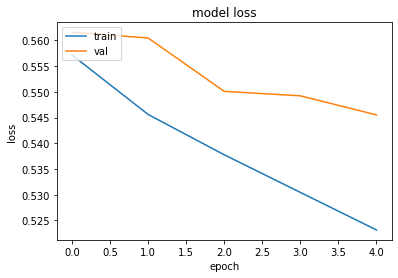

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

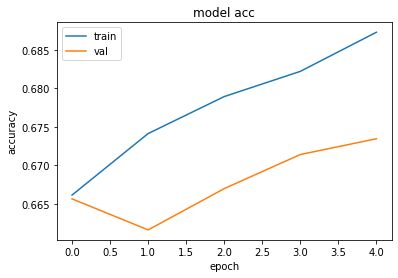

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model Performcance on Test Set


In [98]:
model.evaluate(x_tests, y_test)

157/157 [==============================] - 5s 35ms/step - loss: 0.5402 - accuracy: 0.6839


[0.5402079820632935, 0.6838715076446533]